In [1]:
import torch
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from torch import nn, optim
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import os
import readligo as rl

In [2]:
epochs = 200
test_sample_ratio = .2
input_vector_length = 1024
batch_size = 32
num_bins = 40

input_dir = "/Volumes/Research/GWNMMAD_data/Downsampled/V1/"
input_file_list = ["H-H1_GWOSC_O2_4KHZ_R1-1174978560-4096_downsampled", "L-L1_GWOSC_O2_4KHZ_R1-1187291136-4096_downsampled", "V-V1_GWOSC_O2_4KHZ_R1-1187688448-4096_downsampled"]

input_file = input_file_list[1]

output_dir  = "/Volumes/Research/GWNMMAD_data/Model/"

In [3]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        # Encoder layers
        self.encoder = nn.Sequential(
            nn.Conv1d(1, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(True),
            nn.Conv1d(256, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(True)
        )

        # Decoder layers
        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(True),
            nn.ConvTranspose1d(256, 1, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = x.unsqueeze(1)
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

In [4]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        
        # 编码器
        self.encoder = nn.Sequential(
            nn.Conv1d(1, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, padding=0),
            nn.Conv1d(256, 128, kernel_size=3, padding=1),
            nn.ReLU(),
        )
        
        # 解码器
        self.decoder = nn.Sequential(
            nn.Conv1d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2,mode='nearest'),
            nn.Conv1d(256, 1, kernel_size=3, padding=1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

In [5]:
def min_max_normalization(v):
    v_flattened = v.flatten()
    coef = max(v_flattened)-min(v_flattened)
    minimal = min(v_flattened)
    v_normalized = (v.copy() - minimal) / coef
    return v_normalized, minimal, coef

In [6]:
def bunch_min_max_normalization(v_set):
    recover_min = list(range(len(v_set)))
    recover_coef = list(range(len(v_set)))
    v_set_normalized = np.zeros((v_set.shape[0], v_set.shape[1]))
    for i in range(len(v_set)):
        v_set_normalized[i], recover_min[i], recover_coef[i] = min_max_normalization(v_set[i])
    return v_set_normalized, recover_min, recover_coef

In [7]:
def normal_distribution_normalization(v):
    v_flattened = v.flatten()
    sigma = np.std(v_flattened)
    mean = v_flattened.mean()
    v_normalized = (v.copy()-mean) / sigma
    return v_normalized, mean, sigma

In [8]:
def bunch_standardization(v_set):
    recover_min = list(range(len(v_set)))
    recover_coef = list(range(len(v_set)))
    v_set_normalized = np.zeros((v_set.shape[0], v_set.shape[1]))
    for i in range(len(v_set)):
        v_set_normalized[i], recover_min[i], recover_coef[i] = normal_distribution_normalization(v_set[i])
    return v_set_normalized, recover_min, recover_coef

In [9]:
def normalize(v):
    norm = np.linalg.norm(v)
    junk = 0
    if norm == 0: 
       return v, junk, norm
    return v / norm, junk, norm

In [10]:
def bunch_normalization(v_set):
    recover_min = list(range(len(v_set)))
    recover_coef = list(range(len(v_set)))
    v_set_normalized = np.zeros((v_set.shape[0], v_set.shape[1]))
    for i in range(len(v_set)):
        v_set_normalized[i], recover_min[i], recover_coef[i] = normalize(v_set[i])
    return v_set_normalized, recover_min, recover_coef

In [12]:
data = np.load("/Volumes/Research/GWNMMAD_data/Train_Data/LIGO_noise_data_downsampled_whitened_bandpassed.npy").reshape(-1, 1024)
data_for_training_and_testing = data

In [7]:
data = np.load("D://OneDrive - HKUST Connect/Research/GWNMMAD/Data_cached/LIGO_noise_data_downsampled_whitened_bandpassed.npy").reshape(-1, 1024)
data_for_training_and_testing = data

In [13]:
total_sample_number = data_for_training_and_testing.shape[0]
test_sample_number = int(test_sample_ratio * total_sample_number)
train_sample_number = total_sample_number-test_sample_number


X_train_ini = data_for_training_and_testing[0:train_sample_number-1].copy()
X_test_ini = data_for_training_and_testing[-test_sample_number:].copy()

X_train, X_train_recover_min, X_train_recover_coef = bunch_normalization(X_train_ini)
X_test, X_test_recover_min, X_test_recover_coef = bunch_normalization(X_test_ini)

In [39]:
trainData = torch.FloatTensor(X_train)
testData = torch.FloatTensor(X_test)

In [40]:
train_dataset = TensorDataset(trainData, trainData)
test_dataset = TensorDataset(testData, testData)
trainDataLoader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)


autoencoder = Autoencoder().cuda()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.0005)
loss_func = nn.MSELoss().cuda()
loss_train = np.zeros((epochs, 1))


for epoch in range(epochs):
    for batchidx, (x, _) in enumerate(trainDataLoader):
        x = x.unsqueeze(1).cuda()
        encoded, decoded = autoencoder(x)
        loss = loss_func(decoded, x) 
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
           
    loss_train[epoch,0] = loss.item()  
    print('Epoch: %04d, Training loss=%.8f' %
          (epoch+1, loss.item()))

Epoch: 0001, Training loss=0.00097659
Epoch: 0002, Training loss=0.00097648
Epoch: 0003, Training loss=0.00097653
Epoch: 0004, Training loss=0.00097656
Epoch: 0005, Training loss=0.00097653
Epoch: 0006, Training loss=0.00097656
Epoch: 0007, Training loss=0.00097658
Epoch: 0008, Training loss=0.00097656
Epoch: 0009, Training loss=0.00097659
Epoch: 0010, Training loss=0.00097657
Epoch: 0011, Training loss=0.00097653
Epoch: 0012, Training loss=0.00097654
Epoch: 0013, Training loss=0.00097656
Epoch: 0014, Training loss=0.00097655
Epoch: 0015, Training loss=0.00097655
Epoch: 0016, Training loss=0.00097658
Epoch: 0017, Training loss=0.00097658
Epoch: 0018, Training loss=0.00097654
Epoch: 0019, Training loss=0.00097655
Epoch: 0020, Training loss=0.00097659
Epoch: 0021, Training loss=0.00097657
Epoch: 0022, Training loss=0.00097659
Epoch: 0023, Training loss=0.00097655
Epoch: 0024, Training loss=0.00097659
Epoch: 0025, Training loss=0.00097652
Epoch: 0026, Training loss=0.00097649
Epoch: 0027,

In [19]:
encoded.shape

torch.Size([32, 128, 256])

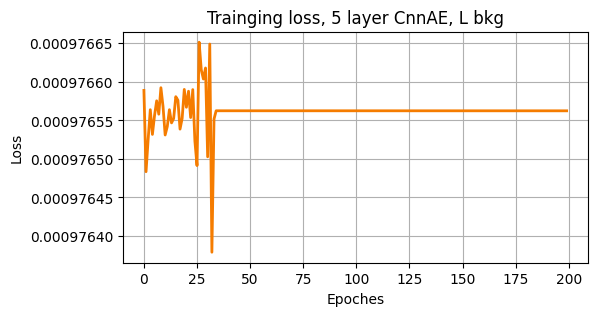

In [41]:
fig = plt.figure(figsize=(6, 3))
ax = plt.subplot(1, 1, 1)
ax.grid()
ax.plot(loss_train, color=[245/255, 124/255, 0/255], linestyle='-', linewidth=2)    
ax.set_xlabel('Epoches')
ax.set_ylabel('Loss')
ax.set_title('Trainging loss, 5 layer CnnAE, L bkg')
plt.show()

In [31]:
_, decodedTestdata = autoencoder(trainData.unsqueeze(1).cuda())
decodedTestdata = decodedTestdata.double()
reconstructedData = decodedTestdata.detach().numpy()
ReconstructedError_train = torch.mean((trainData - reconstructedData)**2,dim=1)
MSE_train = ReconstructedError_train.mean()

OutOfMemoryError: CUDA out of memory. Tried to allocate 19.19 GiB. GPU 0 has a total capacity of 11.99 GiB of which 0 bytes is free. Of the allocated memory 19.51 GiB is allocated by PyTorch, and 21.17 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

Text(0, 0.5, 'Strain')

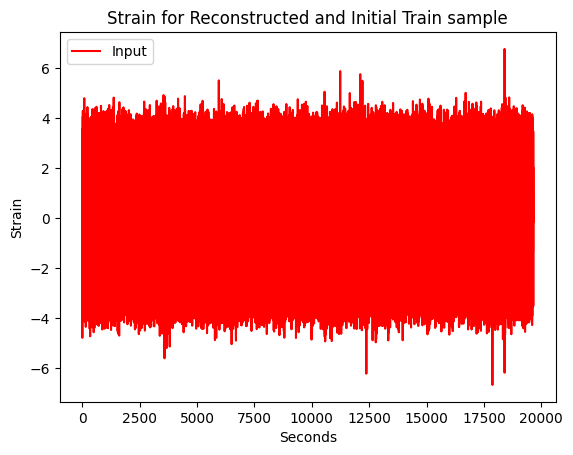

In [35]:
x = np.arange(0, train_sample_number-1, 1/1024)

y = np.zeros((train_sample_number-1, 1024))
# for i in range(train_sample_number-1):
#     y[i] = reconstructedData[i] * X_train_recover_coef + X_train_recover_min
# y = reconstructedData
plt.plot(x, X_train.flatten(), color = 'red', label = 'Input')
# plt.plot(x, y.flatten(), label = 'output')
plt.legend()
plt.title('Strain for Reconstructed and Initial Train sample')
plt.xlabel('Seconds')
plt.ylabel('Strain')